In [2443]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 데이터 불러오기

In [2444]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [2445]:
y = df_train['target']
df_train = df_train.drop(columns='target', axis=1)

In [2446]:
pre_df = pd.DataFrame()
pre_train = pd.DataFrame()
pre_test = pd.DataFrame()

In [2447]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1
concat = pd.concat([df_train, df_test])     # 하나의 데이터로 만들어줍니다.

## 데이터 명목형, 수치형 분류

In [2448]:
num_cols = concat.select_dtypes(include=['int','float']).columns
obj_cols = concat.select_dtypes(include=['object']).columns

In [2449]:
num_cols

Index(['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '해제사유발생일',
       '단지소개기존clob', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'is_test'],
      dtype='object')

In [2450]:
obj_cols

Index(['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'],
      dtype='object')

In [2451]:
print(f'전체 col 수 : {len(concat.columns)}')
print('------------------')
print(f'수치형 col 수 : {len(num_cols)}')
print(f'명목형 col 수 : {len(obj_cols)}')

전체 col 수 : 52
------------------
수치형 col 수 : 23
명목형 col 수 : 29


In [2452]:
concat.head(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0


### 명목형 변수

#### 시군구

In [2453]:
concat['시군구'].isnull().sum()

0

In [2454]:
pre_df['is_test'] = concat['is_test']

In [2455]:
pre_df['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [2456]:
len(pre_df.query('is_test==1'))

9272

In [2457]:
pre_df['시'] = concat['시군구'].str.split(expand=True)[0]
pre_df['구'] = concat['시군구'].str.split(expand=True)[1]
pre_df['동'] = concat['시군구'].str.split(expand=True)[2]

concat.drop(columns=['시군구'], axis=1, inplace=True)

In [2458]:
pre_df.head(2)

,is_test,시,구,동
0,0,서울특별시,강남구,개포동
1,0,서울특별시,강남구,개포동


In [2459]:
pre_df['시'].value_counts()

서울특별시    1128094
Name: 시, dtype: int64

In [2460]:
pre_df.drop(columns=['시'], axis=1, inplace=True)

In [2461]:
pre_df['구'].value_counts()

노원구     115837
송파구      74444
강남구      69656
강서구      67041
강동구      62425
구로구      57983
성북구      57160
양천구      54441
서초구      53553
도봉구      52872
영등포구     48097
동작구      40867
마포구      40810
동대문구     40068
성동구      39831
은평구      38664
중랑구      37303
관악구      36243
서대문구     33272
광진구      22252
강북구      22137
용산구      20682
금천구      19738
중구       13534
종로구       9184
Name: 구, dtype: int64

In [2462]:
pre_df = pd.concat([pre_df, pd.get_dummies(pre_df['구'])], axis=1)

In [2463]:
pre_df.drop(columns=['구'], axis=1, inplace=True)

In [2464]:
result = pre_df['동'].value_counts().sort_values()

In [2465]:
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}

In [2466]:
pre_df['동'] = pre_df['동'].map(value_to_label)

In [2467]:
pre_df['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [2468]:
len(pre_df.query('is_test==1'))

9272

#### 아파트명

In [2469]:
pre_df.reset_index(drop=True, inplace=True)

In [2470]:
concat['아파트명'].isnull().sum()

2136

In [2471]:
len(pre_df.query('is_test==1'))

9272

In [2472]:
tmp_0 = concat.query('is_test==0')
tmp_1 = concat.query('is_test==1')

In [2473]:
len(concat), len(pre_df)

(1128094, 1128094)

In [2474]:
tmp_0['아파트명'].isnull().sum()

2126

In [2475]:
len(nan_index)

2126

In [2476]:
nan_index = tmp_0[tmp_0['아파트명'].isnull()].index

In [2477]:
pre_df.loc[nan_index]['is_test'].value_counts() # ?

0    2126
Name: is_test, dtype: int64

In [2478]:
tmp_0.drop(nan_index, inplace=True)
tmp_0.reset_index(inplace=True, drop=True)

In [2479]:
concat = pd.concat([tmp_0, tmp_1]) 
concat.reset_index(inplace=True, drop=True)

In [2480]:
y.drop(nan_index, inplace=True)
y.reset_index(inplace=True, drop=True)

pre_df.drop(nan_index, inplace=True)
pre_df.reset_index(inplace=True, drop=True)

In [2481]:
len(concat[concat['is_test'] == 1])

9272

In [2482]:
len(pre_df.query('is_test==1'))

9272

In [2483]:
concat['아파트명'].isnull().sum()

10

In [2484]:
concat['아파트명'] = concat['아파트명'].fillna('기타')

In [2485]:
len(concat['아파트명'].value_counts())

6550

In [2486]:
concat['아파트명'] = concat['아파트명'].str.split('', expand=True)[1] + concat['아파트명'].str.split('', expand=True)[2]

In [2487]:
len(concat['아파트명'].value_counts())

1926

In [2488]:
result = concat['아파트명'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['아파트명'] = concat['아파트명'].map(value_to_label)

In [2489]:
result[result == 10].index

Index(['뉴목', '은석', '마인', '실버', '임선', '방산', '천수', '국도', '주승', '혜승', '미광', '도영',
       '자산', '아펠', '성용', '두온', '두암', '금상', '에쉐', '기타', '동승', '대암', '태림', '태상',
       '장방', '토토', '동관', '천보', '주얼', '미양', '상왕', '풍진', '예당', '밀란', '명가', '서로',
       'AP', '갑지', '유풍', '띠에', '오장'],
      dtype='object')

In [2490]:
concat.drop(columns=['아파트명'], axis=1, inplace=True)

In [2491]:
len(pre_df.query('is_test==1'))

9272

#### 도로명

In [2492]:
concat['도로명'].isnull().sum()

0

In [2493]:
concat['도로명'] = concat['도로명'].str.split(' ', expand=True)[0]

In [2494]:
concat['도로명'].value_counts()

마들로        13255
올림픽로       12790
섬밭로        10442
해등로        10307
목동동로        9810
           ...  
반포대로9길         1
동일로101길        1
국사봉6길          1
동산로10길         1
송정길            1
Name: 도로명, Length: 3601, dtype: int64

In [2495]:
concat['도로명'] = concat['도로명'].str.replace(r'\d+(가|나|다|라|마|바|사|아|자|차|카|타|파|하)?길', '', regex=True)
concat['도로명'].value_counts()

동일로      35115
올림픽로     19757
덕릉로      17242
양천로      15821
한글비석로    15416
         ...  
비봉길          4
위례송파로        3
숭문           3
과천대로         2
송정길          1
Name: 도로명, Length: 578, dtype: int64

In [2496]:
result = concat['도로명'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['도로명'] = concat['도로명'].map(value_to_label)
concat.drop(columns=['도로명'], axis=1, inplace=True)

#### 거래유형

In [2497]:
concat['거래유형'].isnull().sum()

0

In [2498]:
concat['거래유형'].value_counts()

-       1084480
중개거래      38010
직거래        3478
Name: 거래유형, dtype: int64

In [2499]:
pre_df[['거래유형_-', '거래유형_중개거래','거래유형_직거래']] = pd.get_dummies(concat, columns=['거래유형'], prefix="거래유형")[['거래유형_-', '거래유형_중개거래','거래유형_직거래']]

In [2500]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = pre_df.query('is_test==0')
pre_test = pre_df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(['is_test'], axis = 1, inplace=True)
pre_test.drop(['is_test'], axis = 1, inplace=True)
print(pre_train.shape, pre_test.shape, y.shape)

pre_train.to_csv("../data/pre_train.csv", index=False)
pre_test.to_csv("../data/pre_test.csv", index=False)
y.to_csv("../data/target.csv", index=False)

(1116696, 31) (9272, 31) (1116696,)


In [2501]:
concat.drop(columns=['거래유형'], axis=1, inplace=True)

#### 중개사소재지

In [2502]:
concat['중개사소재지'].isnull().sum()

0

In [2503]:
concat['중개사소재지'].value_counts()

-                  1088000
서울 노원구                2627
서울 송파구                2538
서울 강남구                2506
서울 강동구                2038
                    ...   
서울 송파구, 인천 계양구           1
경기 연천군, 서울 송파구           1
부산 해운대구, 서울 송파구          1
경기 김포시, 서울 송파구           1
서울 중랑구, 인천 부평구           1
Name: 중개사소재지, Length: 737, dtype: int64

In [2504]:
pre_df['중개사소재지_개수합'] = concat['중개사소재지'].str.split(',', expand=True).applymap(lambda x: 0 if x in ['-', None] else 1).sum(axis=1)

In [2505]:
pre_df['중개사소재지_개수합'].value_counts()

0    1088000
1      34606
2       3345
3         17
Name: 중개사소재지_개수합, dtype: int64

In [2506]:
pre_df['중개사소재지'] = concat['중개사소재지'].str.split(expand=True)[0]
pre_df['중개사소재지'] = pre_df['중개사소재지'].map(lambda x : 1 if x == '서울' else -1 if  x == '-' else 0)

In [2507]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = pre_df.query('is_test==0')
pre_test = pre_df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(['is_test'], axis = 1, inplace=True)
pre_test.drop(['is_test'], axis = 1, inplace=True)
print(pre_train.shape, pre_test.shape, y.shape)

pre_train.to_csv("../data/pre_train.csv", index=False)
pre_test.to_csv("../data/pre_test.csv", index=False)
y.to_csv("../data/target.csv", index=False)

(1116696, 33) (9272, 33) (1116696,)


In [2508]:
concat.drop(columns=['중개사소재지'], axis=1, inplace=True)

#### 단지분류

In [2509]:
concat['k-단지분류(아파트,주상복합등등)'].isnull().sum() / len(concat)

0.7772396728859079

In [2510]:
concat['k-단지분류(아파트,주상복합등등)'].value_counts()

아파트               238586
주상복합               11450
도시형 생활주택(주상복합)       505
도시형 생활주택(아파트)        155
연립주택                 125
Name: k-단지분류(아파트,주상복합등등), dtype: int64

In [2511]:
concat['k-단지분류(아파트,주상복합등등)'].str.split(expand=True)[0].value_counts()

아파트     238586
주상복합     11450
도시형        660
연립주택       125
Name: 0, dtype: int64

In [2512]:
pre_df['단지분류'] = concat['k-단지분류(아파트,주상복합등등)'].str.split(expand=True)[0]

In [2513]:
pre_df['단지분류'] = pre_df['단지분류'].fillna('기타')

In [2514]:
pre_df['단지분류'].value_counts()

기타      875147
아파트     238586
주상복합     11450
도시형        660
연립주택       125
Name: 단지분류, dtype: int64

In [2515]:
result = pre_df['단지분류'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['단지분류'] = pre_df['단지분류'].map(value_to_label)
concat.drop(columns=['k-단지분류(아파트,주상복합등등)'], axis=1, inplace=True)

In [2516]:
pre_df['단지분류'].value_counts()

5    875147
4    238586
3     11450
2       660
1       125
Name: 단지분류, dtype: int64

#### 전화번호

In [2517]:
concat['k-전화번호'].isnull().sum()

874724

In [2518]:
pre_df[['전화번호_0', '전화번호_1', '전화번호_2']] = concat['k-전화번호'].str.extract(r"(\d{2})(\d{3})(\d{4})")

In [2519]:
pre_df['전화번호_0'].value_counts()

02    185183
07        58
Name: 전화번호_0, dtype: int64

In [2520]:
pre_df['전화번호_0'] = pre_df['전화번호_0'].apply(lambda x : 1 if x == '02' else 0)
pre_df['전화번호_0'].value_counts()

0    940785
1    185183
Name: 전화번호_0, dtype: int64

In [2521]:
pre_df['전화번호_1'] = pre_df['전화번호_1'].fillna(-1).astype('int')
pre_df['전화번호_1'].value_counts()

-1      940727
 302      5215
 221      5055
 267      4652
 229      4639
         ...  
 461         4
 896         3
 456         3
 452         1
 220         1
Name: 전화번호_1, Length: 331, dtype: int64

In [2522]:
pre_df['전화번호_2'] = pre_df['전화번호_2'].fillna(-1).astype('int')
pre_df['전화번호_2'].value_counts()

-1       940727
 2883      3068
 6006      2605
 7608      2515
 3863      2385
          ...  
 2930         2
 381          2
 9150         2
 4500         1
 9904         1
Name: 전화번호_2, Length: 703, dtype: int64

In [2523]:
concat.drop(columns=['k-전화번호'], axis=1, inplace=True)

#### 팩스번호

In [2524]:
concat['k-팩스번호'].isnull().sum()

877222

In [2525]:
pre_df[['팩스번호_0', '팩스번호_1', '팩스번호_2']] = concat['k-팩스번호'].str.extract(r"(\d{2})(\d{3})(\d{4})")

In [2526]:
pre_df['팩스번호_0'].value_counts()

02    68689
07       14
Name: 팩스번호_0, dtype: int64

In [2527]:
pre_df['팩스번호_0'] = pre_df['팩스번호_0'].apply(lambda x : 1 if x == '02' else 0)
pre_df['팩스번호_0'].value_counts()

0    1057279
1      68689
Name: 팩스번호_0, dtype: int64

In [2528]:
pre_df['팩스번호_1'] = pre_df['팩스번호_1'].fillna(-1).astype('int')
pre_df['팩스번호_1'].value_counts()

-1      1057265
 266       4995
 561       2425
 577       2254
 341       2000
         ...   
 908          2
 813          2
 452          1
 593          1
 587          1
Name: 팩스번호_1, Length: 320, dtype: int64

In [2529]:
pre_df['팩스번호_2'] = pre_df['팩스번호_2'].fillna(-1).astype('int')
pre_df['팩스번호_2'].value_counts()

-1       1057265
 3140       2425
 4559       2144
 6767       1421
 8647       1200
          ...   
 8062          1
 4533          1
 391           1
 5419          1
 8156          1
Name: 팩스번호_2, Length: 686, dtype: int64

In [2530]:
concat.drop(columns=['k-팩스번호'], axis=1, inplace=True)

#### 세대타입

In [2531]:
concat['k-세대타입(분양형태)'].isnull().sum()

873999

In [2532]:
concat['k-세대타입(분양형태)'].value_counts()

분양    208098
기타     41638
임대      2233
Name: k-세대타입(분양형태), dtype: int64

In [2533]:
pre_df['세대타입'] = concat['k-세대타입(분양형태)'].fillna('미정')

In [2534]:
result = pre_df['세대타입'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['세대타입'] = pre_df['세대타입'].map(value_to_label)
concat.drop(columns=['k-세대타입(분양형태)'], axis=1, inplace=True)

#### 관리방식

In [2535]:
concat['k-관리방식'].isnull().sum()

873999

In [2536]:
concat['k-관리방식'].value_counts()

위탁관리    230361
자치관리     18144
직영        3464
Name: k-관리방식, dtype: int64

In [2537]:
pre_df['관리방식'] = concat['k-관리방식'].fillna('미정')

In [2538]:
result = pre_df['관리방식'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['관리방식'] = pre_df['관리방식'].map(value_to_label)
concat.drop(columns=['k-관리방식'], axis=1, inplace=True)

#### 복도유형

In [2539]:
concat['k-복도유형'].isnull().sum()

874328

In [2540]:
concat['k-복도유형'].value_counts()

계단식    124964
혼합식     85513
복도식     38710
타워형      1371
기타       1082
Name: k-복도유형, dtype: int64

In [2541]:
pre_df['복도유형'] = concat['k-복도유형'].fillna('미정')

In [2542]:
result = pre_df['복도유형'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['복도유형'] = pre_df['복도유형'].map(value_to_label)
concat.drop(columns=['k-복도유형'], axis=1, inplace=True)

#### 난방방식

In [2543]:
concat['k-난방방식'].isnull().sum()

873999

In [2544]:
concat['k-난방방식'].value_counts()

개별난방    152365
지역난방     84826
중앙난방     12687
기타        2091
Name: k-난방방식, dtype: int64

In [2545]:
pre_df['난방방식'] = concat['k-난방방식'].fillna('미정')

In [2546]:
result = pre_df['난방방식'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['난방방식'] = pre_df['난방방식'].map(value_to_label)
concat.drop(columns=['k-난방방식'], axis=1, inplace=True)

#### 건설사

In [2547]:
concat['k-건설사(시공사)'].isnull().sum()

875511

In [2548]:
concat['k-건설사(시공사)'].value_counts()

삼성물산         14259
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: k-건설사(시공사), Length: 344, dtype: int64

In [2549]:
pre_df['건설사'] = concat['k-건설사(시공사)'].str.split(' ', expand=True)[0]

In [2550]:
pre_df['건설사'].value_counts()

삼성물산         14505
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: 건설사, Length: 332, dtype: int64

In [2551]:
pre_df['건설사'] = pre_df['건설사'].str.replace(r"\(.*?\)", "", regex=True).str.strip()

In [2552]:
pre_df['건설사'] = pre_df['건설사'].str.split('', expand=True)[1] + pre_df['건설사'].str.split('', expand=True)[2]

In [2553]:
pre_df['건설사'].value_counts()

현대    32807
삼성    27433
대우    19651
대림     9248
GS     8622
      ...  
호반       22
kc       20
신영        3
자이        2
혜림        1
Name: 건설사, Length: 148, dtype: int64

In [2554]:
pre_df['건설사'] = pre_df['건설사'].fillna('미정')

In [2555]:
result = pre_df['건설사'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['건설사'] = pre_df['건설사'].map(value_to_label)
concat.drop(columns=['k-건설사(시공사)'], axis=1, inplace=True)

#### 시행사

In [2556]:
concat['k-시행사'].isnull().sum()

875708

In [2557]:
concat['k-시행사'].value_counts()

SH공사              12604
대한주택공사             7784
도시개발공사             4284
sh공사               4194
재건축조합              4065
                  ...  
(주)에스떠블유산업개발          2
청명종합건설(주)             2
사당3주택재건축정비사업조합        2
개포우성9차모델링조합           2
한호건설(주)               2
Name: k-시행사, Length: 556, dtype: int64

In [2558]:
pre_df['시행사'] = concat['k-시행사'].str.split(' ', expand=True)[0]

In [2559]:
pre_df['시행사'].value_counts()

SH공사              12604
대한주택공사             7784
서울시                5687
도시개발공사             4284
sh공사               4194
                  ...  
(주)에스떠블유산업개발          2
청명종합건설(주)             2
사당3주택재건축정비사업조합        2
개포우성9차모델링조합           2
한호건설(주)               2
Name: 시행사, Length: 548, dtype: int64

In [2560]:
pre_df['시행사'] = pre_df['시행사'].str.replace(r"\(.*?\)", "", regex=True).str.strip()

In [2561]:
pre_df['시행사'] = pre_df['시행사'].str.split('', expand=True)[1] + pre_df['시행사'].str.split('', expand=True)[2]

In [2562]:
pre_df['시행사'].value_counts()

SH    16952
서울    11183
현대    10835
대한     9017
삼성     7145
      ...  
증산        6
홍은        6
한강        5
청명        2
한호        2
Name: 시행사, Length: 335, dtype: int64

In [2563]:
pre_df['시행사'] = pre_df['시행사'].fillna('미정')

In [2564]:
result = pre_df['시행사'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['시행사'] = pre_df['시행사'].map(value_to_label)
concat.drop(columns=['k-시행사'], axis=1, inplace=True)

#### 사용검사일-사용승인일

In [2565]:
concat['k-사용검사일-사용승인일'].isnull().sum()

874133

In [2566]:
concat['k-사용검사일-사용승인일'] = pd.to_datetime(concat['k-사용검사일-사용승인일'])

In [2567]:
pre_df['사용검사일_년'] = concat['k-사용검사일-사용승인일'].dt.year
pre_df['사용검사일_월'] = concat['k-사용검사일-사용승인일'].dt.month
pre_df['사용검사일_일'] = concat['k-사용검사일-사용승인일'].dt.day

In [2568]:
pre_df['사용검사일_일'].median()

20.0

In [2569]:
pre_df['사용검사일_년'] = pre_df['사용검사일_년'].fillna(0)
pre_df['사용검사일_월'] = pre_df['사용검사일_월'].fillna(0)
pre_df['사용검사일_일'] = pre_df['사용검사일_일'].fillna(0)

In [2570]:
concat.drop(columns=['k-사용검사일-사용승인일'], axis=1, inplace=True)

#### 홈페이지

In [2571]:
concat['k-홈페이지'].isnull().sum()

1011397

In [2572]:
concat['k-홈페이지'].value_counts()

없음                                                        3628
www.jsls.co.kr                                            3068
gaepo001@naver.com                                        2816
www.oftapt.com                                            2605
성산시영.apt.co.kr                                            2385
                                                          ... 
bbgran.xisad.co.kr                                           7
www. 자양12구역지역재개발조합                                           7
cafe.naver.com                                               6
thesharp-trieh.hthomeservice.com/#/feeManage?_k=vm58ep       2
http://www.i-sh.co.kr/happy/intro.do                         1
Name: k-홈페이지, Length: 221, dtype: int64

In [2573]:
concat['k-홈페이지'] = concat['k-홈페이지'].fillna('없음')

In [2574]:
pre_df['홈페이지'] = concat['k-홈페이지'].map(lambda x : 0 if x == '없음' else 1)

In [2575]:
concat.drop(columns=['k-홈페이지'], axis=1, inplace=True)

#### 등록일자, 수정일자

In [2576]:
print(concat['k-등록일자'].isnull().sum(), concat['k-수정일자'].isnull().sum())

1114260 874044


In [2577]:
concat['k-등록일자'] = pd.to_datetime(concat['k-등록일자'])
concat['k-수정일자'] = pd.to_datetime(concat['k-수정일자'])

In [2578]:
pre_df['등록일자_년'] = concat['k-등록일자'].dt.year
pre_df['등록일자_월'] = concat['k-등록일자'].dt.month
pre_df['등록일자_일'] = concat['k-등록일자'].dt.day

pre_df['수정일자_년'] = concat['k-수정일자'].dt.year
pre_df['수정일자_월'] = concat['k-수정일자'].dt.month
pre_df['수정일자_일'] = concat['k-수정일자'].dt.day

In [2579]:
pre_df = pre_df.fillna(0)

In [2580]:
concat.drop(columns=['k-등록일자', 'k-수정일자'], axis=1, inplace=True)

#### 고용관리번호

In [2581]:
concat['고용보험관리번호'].isnull().sum()

918631

In [2582]:
concat['고용보험관리번호'].value_counts()

909-01-23103-1    3068
21380014370       2816
908-00-99517-1    2592
907-009-67911     2480
907-00-16928-1    2385
                  ... 
92023031541         28
91919837281         20
918-15-59912-1      15
206-82-61203-0       3
21780016330          1
Name: 고용보험관리번호, Length: 526, dtype: int64

In [2583]:
concat['고용보험관리번호'] = concat['고용보험관리번호'].str.replace('-', '')
concat['고용보험관리번호'].value_counts()

90901231031    3068
21380014370    2816
90800995171    2592
90700967911    2480
90700169281    2385
               ... 
92023031541      28
91919837281      20
91815599121      15
20682612030       3
21780016330       1
Name: 고용보험관리번호, Length: 525, dtype: int64

In [2584]:
concat['고용보험관리번호'] = concat['고용보험관리번호'].str.slice(0,3)
concat['고용보험관리번호'].value_counts()

907    71316
909    12181
908    11971
910     8432
209     7653
       ...  
301       73
141       70
921       52
558       46
104       33
Name: 고용보험관리번호, Length: 73, dtype: int64

In [2585]:
pre_df['고용보험관리번호'] = concat['고용보험관리번호']
pre_df['고용보험관리번호'] = pre_df['고용보험관리번호'].fillna(000)

In [2586]:
pre_df['고용보험관리번호'] = pre_df['고용보험관리번호'].astype('int')

In [2587]:
concat.drop(columns = ['고용보험관리번호'], axis=1, inplace=True)

#### 경비비관리형태

In [2588]:
concat['경비비관리형태'].isnull().sum()

875435

In [2589]:
concat['경비비관리형태'].value_counts()

위탁       208757
직영        33791
위탁+직영      6168
기타         1817
Name: 경비비관리형태, dtype: int64

In [2590]:
pre_df['경비비관리형태'] = concat['경비비관리형태'].fillna('미정')

In [2591]:
result = pre_df['경비비관리형태'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['경비비관리형태'] = pre_df['경비비관리형태'].map(value_to_label)
concat.drop(columns=['경비비관리형태'], axis=1, inplace=True)

#### 세대전기계약방법

In [2592]:
concat['세대전기계약방법'].isnull().sum()

883263

In [2593]:
concat['세대전기계약방법'].value_counts()

종합계약    124610
단일계약    118095
Name: 세대전기계약방법, dtype: int64

In [2594]:
pre_df['세대전기계약방법'] = concat['세대전기계약방법'].fillna('모름')

In [2595]:
pre_df['세대전기계약방법'].value_counts()

모름      883263
종합계약    124610
단일계약    118095
Name: 세대전기계약방법, dtype: int64

In [2596]:
result = pre_df['세대전기계약방법'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['세대전기계약방법'] = pre_df['세대전기계약방법'].map(value_to_label)
concat.drop(columns=['세대전기계약방법'], axis=1, inplace=True)

#### 청소비관리형태

In [2597]:
concat['청소비관리형태'].isnull().sum()

875625

In [2598]:
concat['청소비관리형태'].value_counts()

위탁       227511
직영        15174
위탁+직영      4179
기타         3479
Name: 청소비관리형태, dtype: int64

In [2599]:
pre_df['청소비관리형태'] = concat['청소비관리형태'].fillna('모름')

In [2600]:
pre_df['청소비관리형태'].value_counts()

모름       875625
위탁       227511
직영        15174
위탁+직영      4179
기타         3479
Name: 청소비관리형태, dtype: int64

In [2601]:
result = pre_df['청소비관리형태'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['청소비관리형태'] = pre_df['청소비관리형태'].map(value_to_label)
concat.drop(columns=['청소비관리형태'], axis=1, inplace=True)

#### 기타/의무/임대/임의

In [2602]:
concat['기타/의무/임대/임의=1/2/3/4'].isnull().sum()

873999

In [2603]:
concat['기타/의무/임대/임의=1/2/3/4'].value_counts()

의무    241849
기타      4186
임의      3701
임대      2233
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

In [2604]:
pre_df['기타/의무/임대/임의'] = concat['기타/의무/임대/임의=1/2/3/4'].fillna('모름')

In [2605]:
result = pre_df['기타/의무/임대/임의'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(result.index, start=1)}
pre_df['기타/의무/임대/임의'] = pre_df['기타/의무/임대/임의'].map(value_to_label)
concat.drop(columns=['기타/의무/임대/임의=1/2/3/4'], axis=1, inplace=True)

#### 단지승인일

In [2606]:
concat['단지승인일'].isnull().sum()

874728

In [2607]:
concat['단지승인일'] = pd.to_datetime(concat['단지승인일'])

In [2608]:
pre_df['단지승인일_년'] = concat['단지승인일'].dt.year
pre_df['단지승인일_월'] = concat['단지승인일'].dt.month
pre_df['단지승인일_일'] = concat['단지승인일'].dt.day

In [2609]:
pre_df = pre_df.fillna(0)

In [2610]:
concat.drop(columns=['단지승인일'], axis=1, inplace=True)

#### 사용허가여부

In [2611]:
concat['사용허가여부'].isnull().sum()

873999

In [2612]:
concat['사용허가여부'].value_counts()

Y    251969
Name: 사용허가여부, dtype: int64

In [2613]:
pre_df['사용허가여부'] = concat['사용허가여부'].fillna('N')

In [2614]:
pre_df['사용허가여부'] = pre_df['사용허가여부'].map(lambda x : 1 if x == 'Y' else 0)

In [2615]:
pre_df['사용허가여부'].value_counts()

0    873999
1    251969
Name: 사용허가여부, dtype: int64

In [2616]:
concat.drop(columns=['사용허가여부'], axis=1, inplace=True)

#### 관리비 업로드

In [2617]:
concat['관리비 업로드'].isnull().sum()

873999

In [2618]:
concat['관리비 업로드'].value_counts()

N    247788
Y      4181
Name: 관리비 업로드, dtype: int64

In [2619]:
concat['관리비 업로드'] = concat['관리비 업로드'].map(lambda x : 1 if x == 'Y' else 0 if x == 'N' else -1)
concat['관리비 업로드'].value_counts()

-1    873999
 0    247788
 1      4181
Name: 관리비 업로드, dtype: int64

In [2620]:
pre_df['관리비업로드'] = concat['관리비 업로드']

In [2621]:
concat.drop(columns=['관리비 업로드'] , axis = 1, inplace=True)

#### 단지신청일

In [2622]:
concat['단지신청일'].isnull().sum()

874061

In [2623]:
concat['단지신청일'] = pd.to_datetime(concat['단지신청일'])

In [2624]:
pre_df['단지신청일_년'] = concat['단지신청일'].dt.year
pre_df['단지신청일_월'] = concat['단지신청일'].dt.month
pre_df['단지신청일_일'] = concat['단지신청일'].dt.day

In [2625]:
pre_df = pre_df.fillna(0)

In [2626]:
concat.drop(columns=['단지신청일'], axis=1, inplace=True)

### 복합 변수

#### 번지 = 본번 + 부번

In [2627]:
concat[['번지', '본번','부번']].isnull().sum()

번지    227
본번     75
부번     75
dtype: int64

In [2628]:
len(concat[concat[['번지', '본번','부번']].isna().all(axis=1)].index)

75

In [2629]:
all_nan = concat[concat[['번지', '본번','부번']].isna().all(axis=1)].index

In [2630]:
concat.iloc[all_nan]['is_test'].value_counts()

0    75
Name: is_test, dtype: int64

In [2631]:
concat.drop(all_nan, inplace=True)
concat = concat.reset_index(drop=True)

pre_df.drop(all_nan, inplace=True)
pre_df = pre_df.reset_index(drop=True)

y.drop(all_nan, inplace=True)
y = y.reset_index(drop=True)

In [2632]:
concat[['번지', '본번','부번']].isnull().sum()

번지    152
본번      0
부번      0
dtype: int64

In [2633]:
pre_df['본번'] = concat['본번']
pre_df['부번'] = concat['부번']

In [2634]:
concat.drop(columns = ['본번', '부번', '번지'], axis=1, inplace=True)

### 수치형 변수

#### 전용면적

In [2635]:
concat['전용면적(㎡)'].isnull().sum()

0

In [2636]:
pre_df['전용면적'] = concat['전용면적(㎡)']

In [2637]:
concat.drop(columns = ['전용면적(㎡)'], axis=1, inplace=True)

#### 계약년월 + 계약일

In [2638]:
concat[['계약년월', '계약일']].isnull().sum()

계약년월    0
계약일     0
dtype: int64

In [2639]:
pre_df['계약_년'] = concat['계약년월'].astype('str').str.slice(0,4).astype('int')
pre_df['계약_월'] = concat['계약년월'].astype('str').str.slice(4,7).astype('int')
pre_df['계약_일'] = concat['계약일']

In [2640]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = pre_df.query('is_test==0')
pre_test = pre_df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(['is_test'], axis = 1, inplace=True)
pre_test.drop(['is_test'], axis = 1, inplace=True)
print(pre_train.shape, pre_test.shape, y.shape)

pre_train.to_csv("../data/pre_train.csv", index=False)
pre_test.to_csv("../data/pre_test.csv", index=False)
y.to_csv("../data/target.csv", index=False)

(1116621, 75) (9272, 75) (1116621,)


In [2641]:
concat.drop(columns=['계약년월', '계약일'], axis=1, inplace=True)

#### 층

In [2642]:
concat['층'].isnull().sum()

0

In [2643]:
pre_df['층'] = concat['층']

In [2644]:
concat.drop(columns=['층'], axis=1, inplace=True)

#### 건축년도

In [2645]:
concat['건축년도'].isnull().sum()

0

In [2646]:
pre_df['건축년도'] = concat['건축년도']

In [2647]:
concat.drop(columns=['건축년도'], axis=1, inplace=True)

#### 등기신청일자

In [2648]:
concat['등기신청일자'].isnull().sum()

0

In [2649]:
concat['등기신청일자'].value_counts()

            1109109
20230630        584
20230831        496
20230428        393
20230731        374
             ...   
20230125          3
20230105          3
20230110          3
20230109          1
20230104          1
Name: 등기신청일자, Length: 181, dtype: int64

In [2650]:
concat.drop(columns=['등기신청일자'], axis=1, inplace=True)

#### 해제사유발생일

In [2651]:
concat['해제사유발생일'].isnull().sum()

1119724

In [2652]:
concat['해제사유발생일'].value_counts()

20220211.0    151
20200727.0     43
20200714.0     40
20200720.0     37
20200715.0     32
             ... 
20210821.0      1
20210530.0      1
20201119.0      1
20210801.0      1
20230909.0      1
Name: 해제사유발생일, Length: 1033, dtype: int64

In [2653]:
concat.drop(columns=['해제사유발생일'], axis=1, inplace=True)

#### 단지소개기존

In [2654]:
concat['단지소개기존clob'].isnull().sum() / len(concat)

0.9385945200831696

In [2655]:
pre_df['단지소개기존'] = concat['단지소개기존clob'].fillna(-1)

In [2656]:
concat.drop(columns=['단지소개기존clob'], axis=1, inplace=True)

#### 전체동수

In [2657]:
concat['k-전체동수'].isnull().sum() / len(concat)

0.7771662138409245

<Axes: >

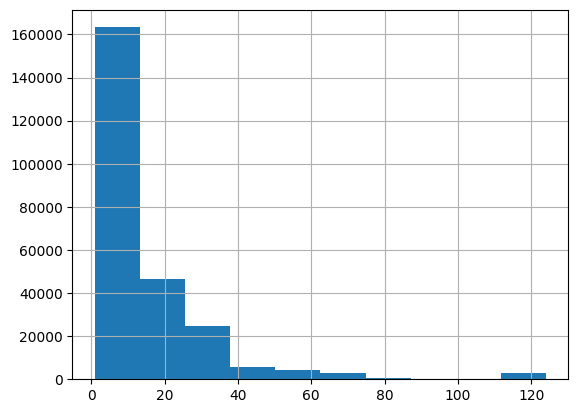

In [2658]:
pre_df['전체동수'] = concat['k-전체동수']
pre_df['전체동수'].hist()

In [2659]:
pre_df['전체동수'] = pre_df['전체동수'].interpolate(method='linear')

<Axes: >

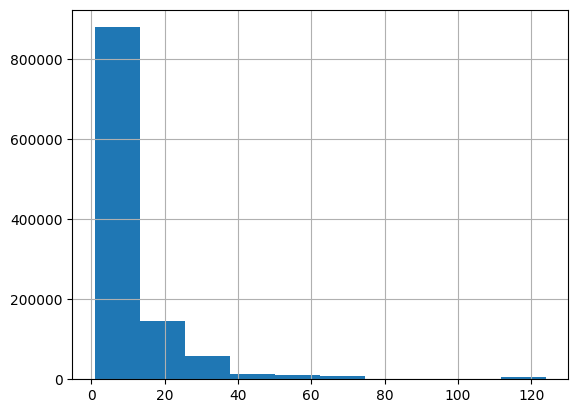

In [2660]:
pre_df['전체동수'].hist()

In [2661]:
concat.drop(columns=['k-전체동수'], axis=1, inplace=True)

#### 전체세대수

In [2662]:
concat['k-전체세대수'].isnull().sum() / len(concat)

0.7762051988954546

In [2663]:
pre_df['전체세대수'] = concat['k-전체세대수']
pre_df['전체세대수'] = pre_df['전체세대수'].interpolate(method='linear')

In [2664]:
concat.drop(columns=['k-전체세대수'], axis=1, inplace=True)

#### 연면적

In [2665]:
concat['k-연면적'].isnull().sum() / len(concat)

0.7762051988954546

In [2666]:
pre_df['연면적'] = concat['k-연면적']
pre_df['연면적'] = pre_df['연면적'].interpolate(method='linear')

In [2667]:
concat.drop(columns=['k-연면적'], axis=1, inplace=True)

#### 주거전용면적

In [2668]:
concat['k-주거전용면적'].isnull().sum() / len(concat)

0.7762451671695267

In [2669]:
pre_df['주거전용면적'] = concat['k-주거전용면적']
pre_df['주거전용면적'] = pre_df['주거전용면적'].interpolate(method='linear')

In [2670]:
concat.drop(columns=['k-주거전용면적'], axis=1, inplace=True)

#### 관리비부과면적

In [2671]:
concat['k-관리비부과면적'].isnull().sum() / len(concat)

0.7762051988954546

In [2672]:
pre_df['관리비부과면적'] = concat['k-관리비부과면적']
pre_df['관리비부과면적'] = pre_df['관리비부과면적'].interpolate(method='linear')

In [2673]:
concat.drop(columns=['k-관리비부과면적'], axis=1, inplace=True)

#### 전용면적별세대현황

In [2674]:
concat.rename(
    columns={
        'k-전용면적별세대현황(60㎡이하)' : '60이하',
        'k-전용면적별세대현황(60㎡~85㎡이하)' : '85이하',
        'k-85㎡~135㎡이하' : '135이하',
        'k-135㎡초과' : '135초과'
    }, inplace=True
)

In [2675]:
tmp_cols = ['60이하', '85이하','135이하', '135초과']

In [2676]:
concat[tmp_cols].isnull().sum()

60이하      873969
85이하      873969
135이하     873969
135초과    1125564
dtype: int64

In [2677]:
pre_df['전용면적별세대현황합'] = (concat[tmp_cols] * [1,2,3,4]).sum(axis=1)

In [2678]:
pre_df['전용면적별세대현황합'] = pre_df['전용면적별세대현황합'].interpolate(method='linear')

In [2679]:
concat.drop(columns=tmp_cols, axis=1, inplace=True)

#### 건축면적

In [2680]:
concat['건축면적'].isnull().sum()

874078

In [2681]:
pre_df['건축면적'] = concat['건축면적']
pre_df['건축면적'] = pre_df['건축면적'].interpolate(method='linear')

In [2682]:
concat.drop(columns=['건축면적'], axis=1, inplace=True)

#### 주차대수

In [2683]:
concat['주차대수'].isnull().sum()

874076

In [2684]:
pre_df['주차대수'] = concat['주차대수']
pre_df['주차대수'] = pre_df['주차대수'].interpolate(method='linear')

In [2685]:
concat.drop(columns=['주차대수'], axis=1, inplace=True)

#### 좌표X, 좌표Y

In [2686]:
concat.isnull().sum()

좌표X        874031
좌표Y        874031
is_test         0
dtype: int64

In [2687]:
pre_df[['좌표X', '좌표Y']] = concat[['좌표X', '좌표Y']]
pre_df[['좌표X', '좌표Y']] = pre_df[['좌표X', '좌표Y']].interpolate(method='linear')

In [2688]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = pre_df.query('is_test==0')
pre_test = pre_df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(['is_test'], axis = 1, inplace=True)
pre_test.drop(['is_test'], axis = 1, inplace=True)
print(pre_train.shape, pre_test.shape, y.shape)

pre_train.to_csv("../data/pre_train.csv", index=False)
pre_test.to_csv("../data/pre_test.csv", index=False)
y.to_csv("../data/target.csv", index=False)

(1116621, 88) (9272, 88) (1116621,)
